# Identification and analysis of biomarkers and drug response  for breast cancer

# 1.Loading and cleaning the data

In [317]:
# Import the modules

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

# Data Scaler
from sklearn.preprocessing import StandardScaler

# Regression
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [318]:
# Read the data
data = pd.read_csv('./BC_DR.csv')

In [319]:
# Change the settings so that you can see all columns of the dataframe when calling df.head()
pd.set_option('display.max_columns',999)
data.head()

,Unnamed: 0,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (µM),IC50 (µM),Amax,ActArea,CCLE name,Cell line primary name,Cell line aliases,Gender,Site Primary,Histology,Hist Subtype1,CCLE tumor type,CCLE tumor type 2,Notes,Source,Expression arrays,SNP arrays,Hybrid capture/Sequencing,OncoMap,Drug sensitivity profiling
0,0,AU565_BREAST,AU565,17-AAG,HSP90,0.0025,-18.0,0.28,8,Sigmoid,0.021328,0.023349,-71.350121,4.2668,AU565_BREAST,AU565,NaN,F,breast,carcinoma,NaN,breast,solid,Metastatic pair: SK-BR-3 and AU565 are from th...,ATCC,1,1,1.0,1,1
1,0,AU565_BREAST,AU565,17-AAG,HSP90,0.0080,-13.0,12.30,8,Sigmoid,0.021328,0.023349,-71.350121,4.2668,AU565_BREAST,AU565,NaN,F,breast,carcinoma,NaN,breast,solid,Metastatic pair: SK-BR-3 and AU565 are from th...,ATCC,1,1,1.0,1,1
2,0,AU565_BREAST,AU565,17-AAG,HSP90,0.0250,-55.0,7.15,8,Sigmoid,0.021328,0.023349,-71.350121,4.2668,AU565_BREAST,AU565,NaN,F,breast,carcinoma,NaN,breast,solid,Metastatic pair: SK-BR-3 and AU565 are from th...,ATCC,1,1,1.0,1,1
3,0,AU565_BREAST,AU565,17-AAG,HSP90,0.0800,-72.0,7.16,8,Sigmoid,0.021328,0.023349,-71.350121,4.2668,AU565_BREAST,AU565,NaN,F,breast,carcinoma,NaN,breast,solid,Metastatic pair: SK-BR-3 and AU565 are from th...,ATCC,1,1,1.0,1,1
4,0,AU565_BREAST,AU565,17-AAG,HSP90,0.2500,-69.0,1.84,8,Sigmoid,0.021328,0.023349,-71.350121,4.2668,AU565_BREAST,AU565,NaN,F,breast,carcinoma,NaN,breast,solid,Metastatic pair: SK-BR-3 and AU565 are from th...,ATCC,1,1,1.0,1,1


In [320]:
#Cell line aliases is empty and can be dropped
del data['Cell line aliases']

del data['OncoMap']
del data['Hybrid capture/Sequencing']
del data['SNP arrays']
del data['Expression arrays']
del data['Source']
del data['CCLE tumor type 2']
del data['Histology']
del data['CCLE name']
del data['Site Primary']
del data['Hist Subtype1']
del data['Unnamed: 0']

In [321]:
#checking for duplicates
sum(data.duplicated(data.columns))

0

In [322]:
# Check the number of rows and columns
data.shape

(5215, 18)

In [323]:
# Get a high-level overview of the data types, the amount of NULL values etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5215 entries, 0 to 5214
Data columns (total 18 columns):
CCLE Cell Line Name           5215 non-null object
Primary Cell Line Name        5215 non-null object
Compound                      5215 non-null object
Target                        5215 non-null object
Doses (uM)                    5215 non-null float64
Activity Data (median)        5215 non-null float64
Activity SD                   5215 non-null float64
Num Data                      5215 non-null int64
FitType                       5215 non-null object
EC50 (µM)                     2638 non-null float64
IC50 (µM)                     5215 non-null float64
Amax                          5215 non-null float64
ActArea                       5215 non-null float64
Cell line primary name        5215 non-null object
Gender                        5215 non-null object
CCLE tumor type               5215 non-null object
Notes                         909 non-null object
Drug sensitivity prof

In [324]:
# Capture the necessary data
variables = data.columns

count = []

for variable in variables:
    length = data[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(data), 2)

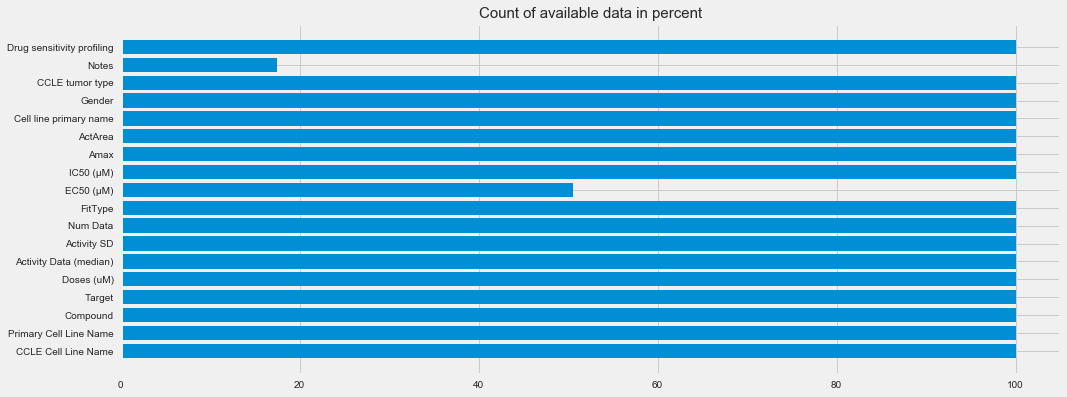

In [325]:
#Plot number of available data per variable
plt.figure(figsize=(15,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

In [326]:
#data['EC50 (µM)'].fillna(data.mean())
data['EC50 (µM)'].fillna((data['EC50 (µM)'].mean()), inplace=True)
data['Doses (uM)'].fillna((data['Doses (uM)'].mean()), inplace=True)


In [327]:
# Capture the necessary data
variables = data.columns

count = []

for variable in variables:
    length = data[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(data), 2)

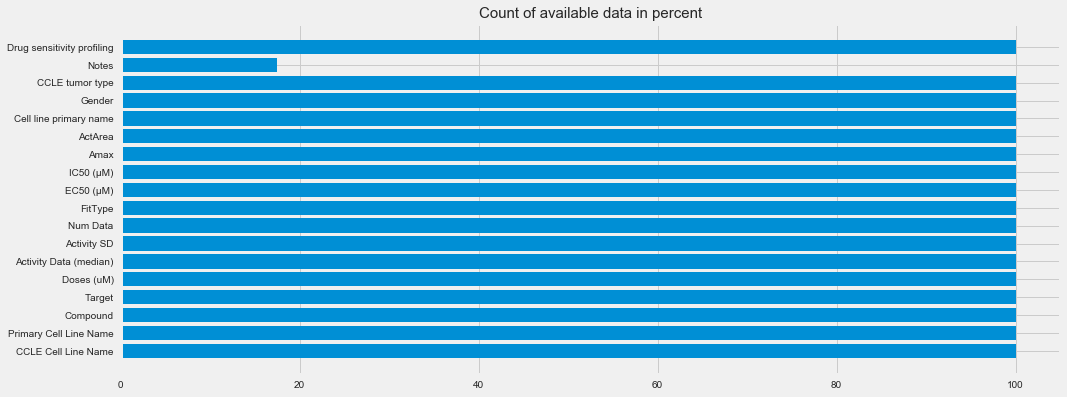

In [328]:
#Plot number of available data per variable
plt.figure(figsize=(15,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

In [329]:
data.describe()

,Doses (uM),Activity Data (median),Activity SD,Num Data,EC50 (µM),IC50 (µM),Amax,ActArea,Drug sensitivity profiling
count,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.0
mean,1.462923,-14.118186,11.064635,7.987919,3.264169,5.828403,-37.398659,1.226075,1.0
std,2.598660,30.179587,10.198943,0.109256,2.450422,3.189292,35.286917,1.414451,0.0
min,0.002500,-143.000000,0.000000,7.000000,0.002682,0.002543,-143.366989,0.000000,1.0
25%,0.025000,-24.000000,3.620000,8.000000,1.824442,2.759405,-66.779556,0.276800,1.0
50%,0.250000,-5.800000,8.300000,8.000000,3.264169,8.000000,-34.255409,0.676200,1.0
75%,2.530000,5.045000,15.600000,8.000000,3.264169,8.000000,-4.111075,1.609600,1.0
max,8.000000,80.700000,79.500000,8.000000,9.532790,8.000000,16.705908,6.881900,1.0


# 2.Data variable inspection

## 2.1.Dependent Variable Inspection

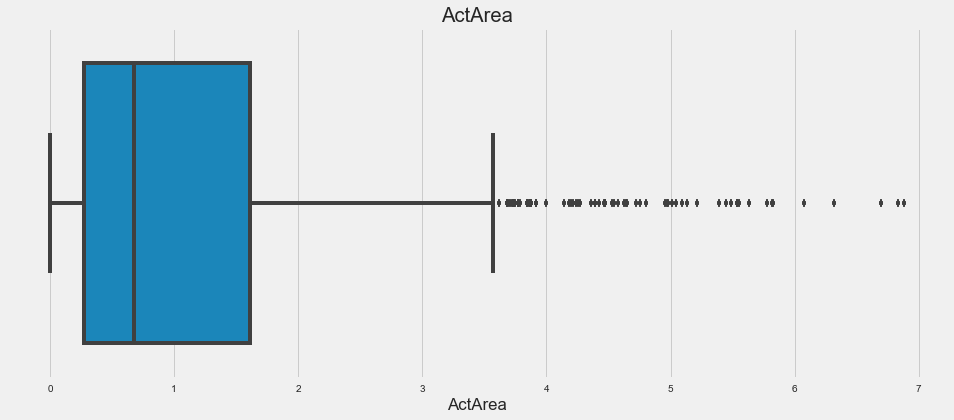

In [330]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='ActArea', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('ActArea')
plt.show()

In [331]:
#data=data[((data['ActArea'] >3.7) & (data['ActArea']<5.5))]

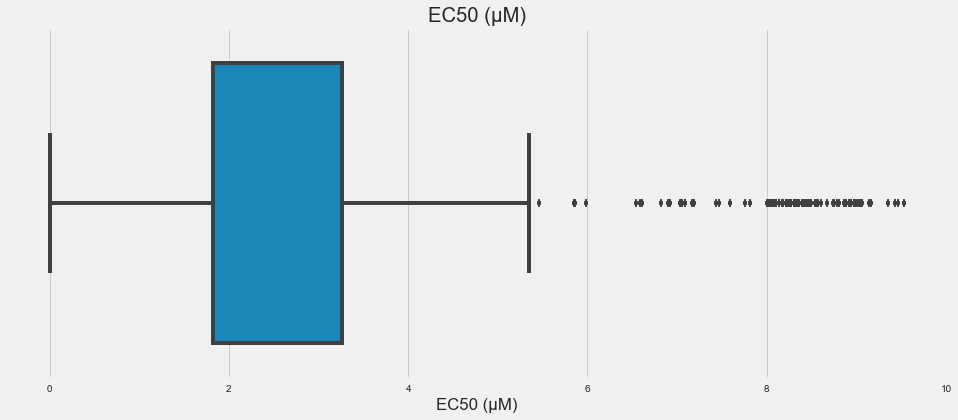

In [332]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='EC50 (µM)', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('EC50 (µM)')
plt.show()


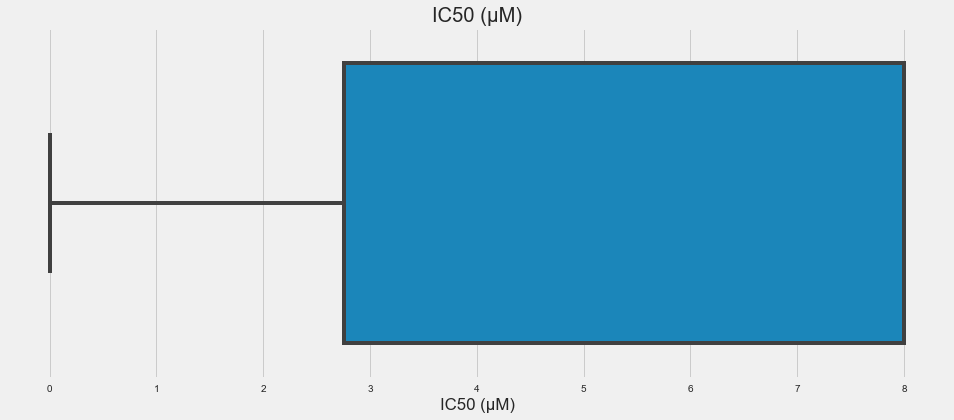

In [333]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='IC50 (µM)', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('IC50 (µM)')
plt.show()

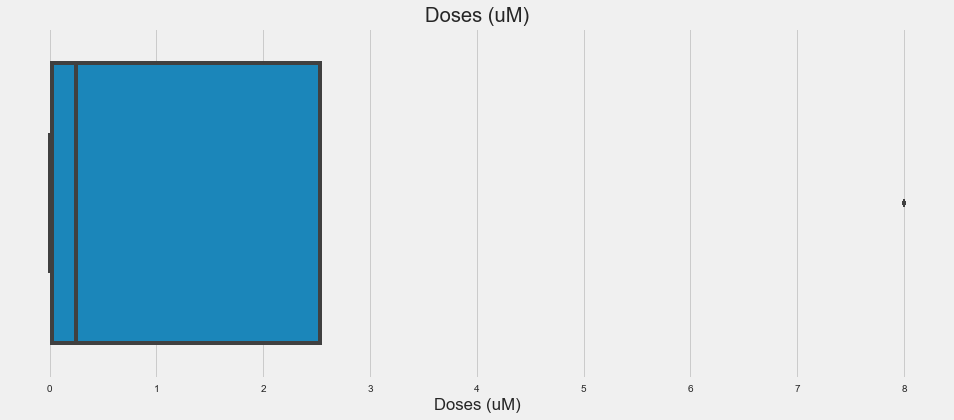

In [334]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='Doses (uM)', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Doses (uM)')
plt.show()

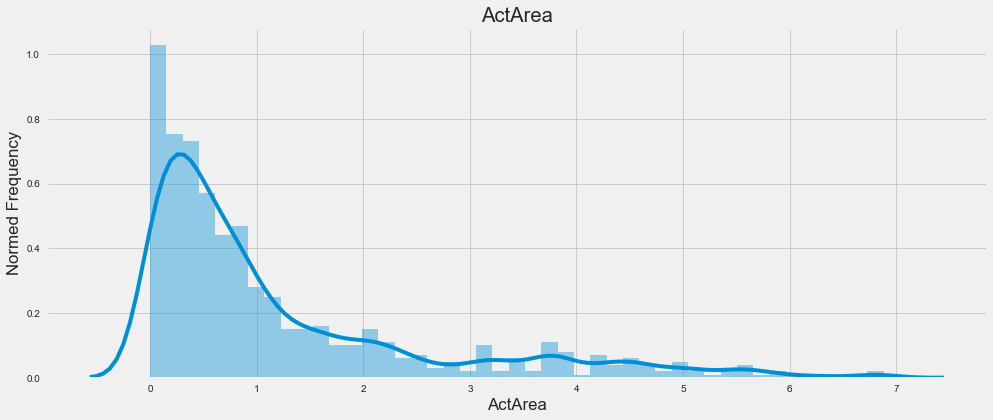

In [335]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.distplot(data['ActArea'])
plt.title('ActArea')
plt.ylabel('Normed Frequency')
plt.show()

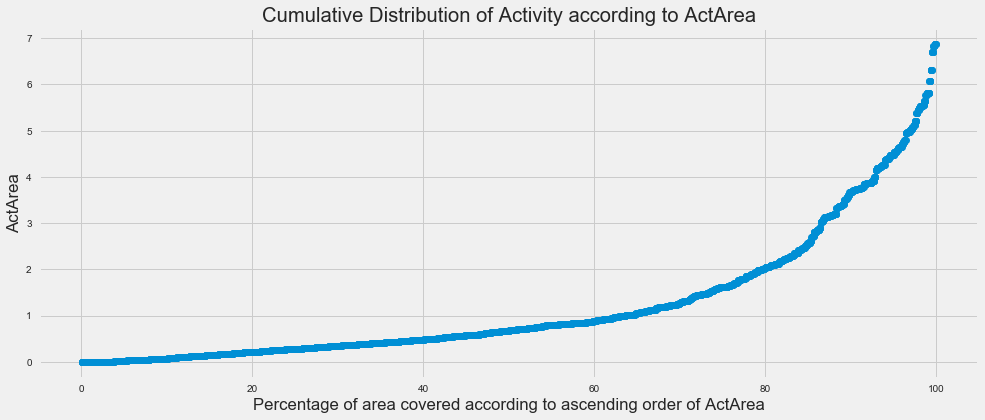

In [336]:
#Set the size of the plot
plt.figure(figsize=(15,6))

#Get the data and format it
x = data[['ActArea']].sort_values(by='ActArea').reset_index()
x['Activity PROPORTION'] = 1
x['Activity PROPORTION'] = x['Activity PROPORTION'].cumsum()
x['Activity PROPORTION'] = 100* x['Activity PROPORTION'] / len(x['Activity PROPORTION'])

# Plot the data and configure the settings
plt.plot(x['Activity PROPORTION'],x['ActArea'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Activity according to ActArea')
plt.xlabel('Percentage of area covered according to ascending order of ActArea')
plt.ylabel('ActArea')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

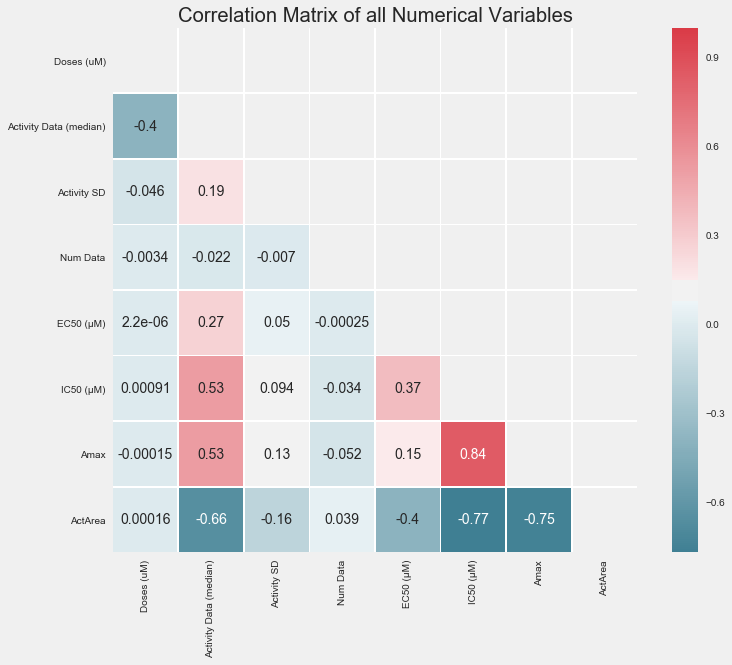

In [337]:
# Correlation Matrix

# Compute the correlation matrix
d= data[["Target","Doses (uM)","Activity Data (median)","Activity SD","Num Data","FitType","EC50 (µM)","IC50 (µM)","Amax",
         "ActArea"]]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

In [338]:
data.describe()

,Doses (uM),Activity Data (median),Activity SD,Num Data,EC50 (µM),IC50 (µM),Amax,ActArea,Drug sensitivity profiling
count,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.000000,5215.0
mean,1.462923,-14.118186,11.064635,7.987919,3.264169,5.828403,-37.398659,1.226075,1.0
std,2.598660,30.179587,10.198943,0.109256,2.450422,3.189292,35.286917,1.414451,0.0
min,0.002500,-143.000000,0.000000,7.000000,0.002682,0.002543,-143.366989,0.000000,1.0
25%,0.025000,-24.000000,3.620000,8.000000,1.824442,2.759405,-66.779556,0.276800,1.0
50%,0.250000,-5.800000,8.300000,8.000000,3.264169,8.000000,-34.255409,0.676200,1.0
75%,2.530000,5.045000,15.600000,8.000000,3.264169,8.000000,-4.111075,1.609600,1.0
max,8.000000,80.700000,79.500000,8.000000,9.532790,8.000000,16.705908,6.881900,1.0


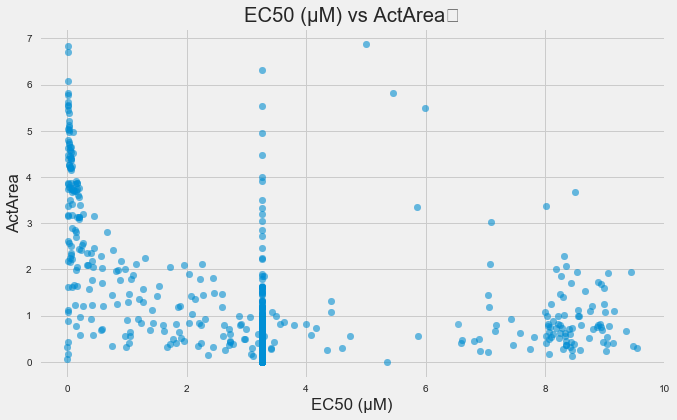

In [339]:
plt.figure(figsize=(10,6))
sns.regplot(x='EC50 (µM)', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('EC50 (µM) vs ActArea	')
plt.show()

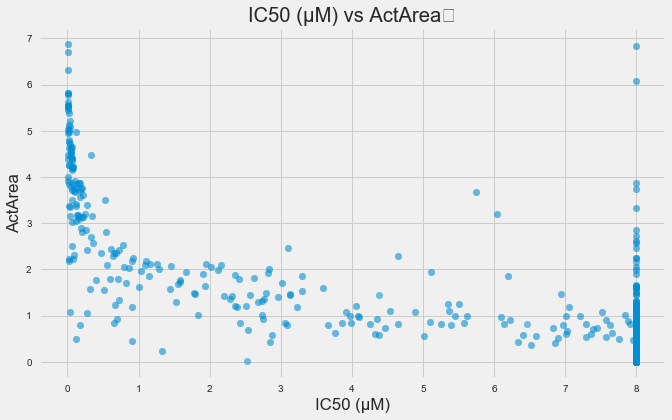

In [340]:
plt.figure(figsize=(10,6))
sns.regplot(x='IC50 (µM)', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('IC50 (µM) vs ActArea	')
plt.show()

In [341]:
#data = data[((data['IC50 (µM)'] >4) &(data['IC50 (µM)'] <0))] 

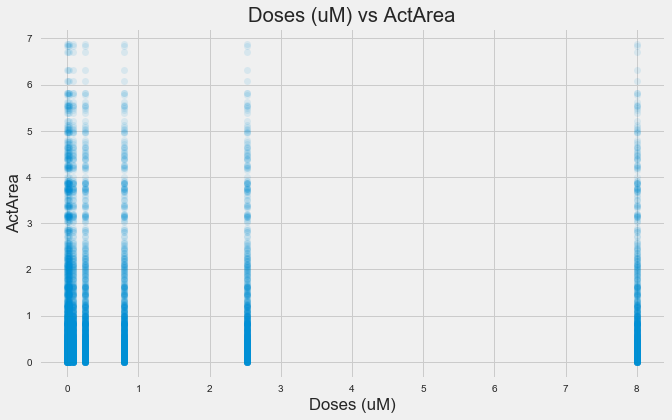

In [342]:
plt.figure(figsize=(10,6))
sns.regplot(x='Doses (uM)', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Doses (uM) vs ActArea')
plt.show()

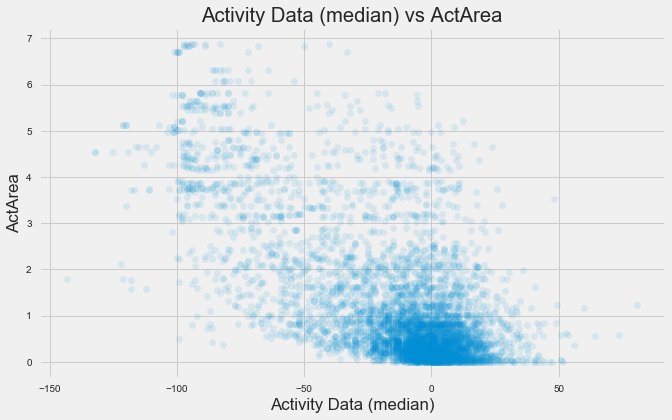

In [343]:
plt.figure(figsize=(10,6))
sns.regplot(x='Activity Data (median)', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Activity Data (median) vs ActArea')
plt.show()

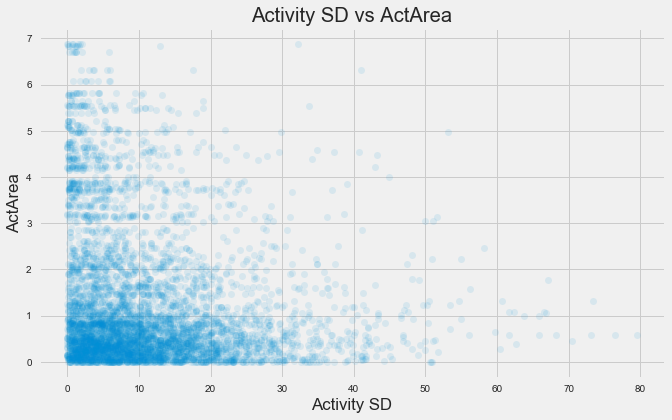

In [344]:
plt.figure(figsize=(10,6))
sns.regplot(x='Activity SD', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Activity SD vs ActArea')
plt.show()

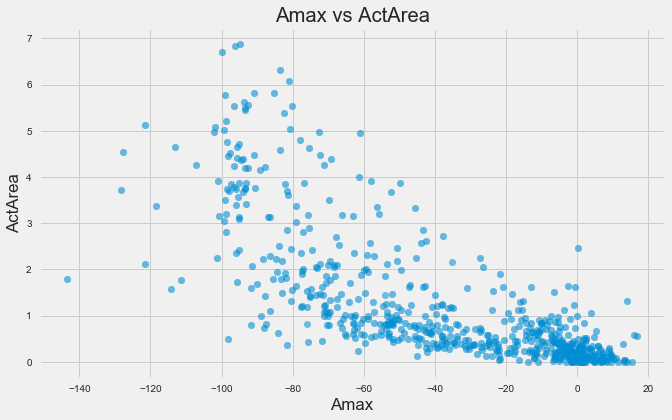

In [345]:
plt.figure(figsize=(10,6))
sns.regplot(x='Amax', y='ActArea', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Amax vs ActArea')
plt.show()

In [346]:
data = data[(data['Amax'] >-120)] 
#data=data[(data['Activity SD']<50)]

In [347]:
data.describe()

,Doses (uM),Activity Data (median),Activity SD,Num Data,EC50 (µM),IC50 (µM),Amax,ActArea,Drug sensitivity profiling
count,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.0
mean,1.462930,-13.761273,11.057021,7.987826,3.284007,5.869107,-36.694255,1.208800,1.0
std,2.598662,29.633615,10.197531,0.109672,2.448227,3.167002,34.490555,1.401366,0.0
min,0.002500,-120.000000,0.000000,7.000000,0.002682,0.002543,-118.422653,0.000000,1.0
25%,0.025000,-24.000000,3.620000,8.000000,1.870323,2.833243,-66.173851,0.274300,1.0
50%,0.250000,-5.700000,8.290000,8.000000,3.264169,8.000000,-33.941879,0.668100,1.0
75%,2.530000,5.125000,15.500000,8.000000,3.264169,8.000000,-3.964913,1.594200,1.0
max,8.000000,80.700000,79.500000,8.000000,9.532790,8.000000,16.705908,6.881900,1.0


# 3. Modelling

In [348]:
#Choose only the variables that has to be used in the model
columns = ["EC50 (µM)","IC50 (µM)","Doses (uM)","Amax","Activity Data (median)","Activity SD","ActArea"]
data_model = data.loc[:,columns]

In [349]:
data_model.head()

,EC50 (µM),IC50 (µM),Doses (uM),Amax,Activity Data (median),Activity SD,ActArea
0,0.021328,0.023349,0.0025,-71.350121,-18.0,0.28,4.2668
1,0.021328,0.023349,0.0080,-71.350121,-13.0,12.30,4.2668
2,0.021328,0.023349,0.0250,-71.350121,-55.0,7.15,4.2668
3,0.021328,0.023349,0.0800,-71.350121,-72.0,7.16,4.2668
4,0.021328,0.023349,0.2500,-71.350121,-69.0,1.84,4.2668


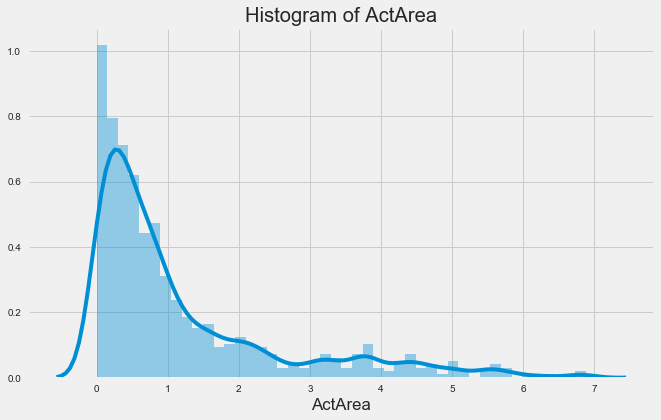

In [350]:
plt.figure(figsize=(10,6))
sns.distplot(data_model['ActArea'])
plt.title('Histogram of ActArea')
plt.show()

In [351]:
data.describe()

,Doses (uM),Activity Data (median),Activity SD,Num Data,EC50 (µM),IC50 (µM),Amax,ActArea,Drug sensitivity profiling
count,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.0
mean,1.462930,-13.761273,11.057021,7.987826,3.284007,5.869107,-36.694255,1.208800,1.0
std,2.598662,29.633615,10.197531,0.109672,2.448227,3.167002,34.490555,1.401366,0.0
min,0.002500,-120.000000,0.000000,7.000000,0.002682,0.002543,-118.422653,0.000000,1.0
25%,0.025000,-24.000000,3.620000,8.000000,1.870323,2.833243,-66.173851,0.274300,1.0
50%,0.250000,-5.700000,8.290000,8.000000,3.264169,8.000000,-33.941879,0.668100,1.0
75%,2.530000,5.125000,15.500000,8.000000,3.264169,8.000000,-3.964913,1.594200,1.0
max,8.000000,80.700000,79.500000,8.000000,9.532790,8.000000,16.705908,6.881900,1.0


In [352]:
data['ActArea'].fillna((data['ActArea'].mean()), inplace=True)

In [353]:
#write the current data into a separate file so that it'll get easier to read

In [354]:
#Split data into training and testing set with 80% of the data going into training
training, testing = train_test_split(data_model, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(data_model.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 5175; training sample size = 4140, testing sample size = 1035


In [355]:
#X are the variables/features that help predict y, which tells us whether an employee left or stayed. This is done for both 
#training and testing
df_train_s = training.loc[:,data_model.columns]
X_train_s = df_train_s.drop(['ActArea'], axis=1)
y_train_s = df_train_s.loc[:, ['ActArea']]

df_test_s = testing.loc[:,data_model.columns]
X_test_s = df_test_s.drop(['ActArea'], axis=1)
y_test_s = df_test_s.loc[:, ['ActArea']]

#print(X_test_s)
#data=
#fd=pd.DataFrame(data)
linreg = LinearRegression()

linreg.fit(X_train_s, y_train_s)
y11=linreg.predict(X_test_s)
#data.reshape(-1, 1)
y = linreg.predict([[3.456,5.67,8.120,-41.45678,-71.987654,2.777777]])
#Nprint(y11)
print(y)

[[1.77363034]]


### 3.1 Running different models
#### Different models that are run are:
#### 1)Ridge Regression
#### 2) Lasso Regression
#### 3) Elasticnet and GridSearch
#### 4) Random Forest Regression
#### 5) Linear regression

In [356]:
data=[]
q1={}
import json
q={}

### Linear Regression

In [357]:
linreg = LinearRegression()
linreg.fit(X_train_s, y_train_s)
y_pred_s = linreg.predict(X_test_s)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_linreg = cross_val_score(linreg, X_train_s, y_train_s, cv=5)


In [358]:
print("R^2: {}".format(linreg.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s))
print("Root Mean Squared Error: {}".format(rmse))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
# Print the 5-fold cross-validation scores
#print("rss".format(RSS))
print(cv_scores_linreg)
q={'linear':{
    'r^2':linreg.score(X_test_s, y_test_s),
    'rmse':rmse,
    '5-fold csv':np.mean(cv_scores_linreg),
    'predicted value':list(y_pred_s)
}
   }
q1.update(q)
data.append(q1)
#print(list(y_pred_s))
# df=pd.DataFrame(y_pred_s,columns=['linear_regression'])
# print(df)
# data['linear_regression']=[q1]
#  print(data)
# json_data=json.dumps(data)
# print(json_data)

# serialized= json.dumps(q1, sort_keys=True, indent=3)
# print(serialized)
# import json

# data = {}
# data['key'] = 'value'
# json_data = json.dumps(data)

R^2: 0.7380975305286707
Root Mean Squared Error: 0.6891162672045735
Average 5-Fold CV Score: 0.7349081777449893
[0.72199511 0.75380116 0.71491167 0.73883825 0.74499469]


In [359]:
#df.head()
#print(df.to_string())

### Ridge

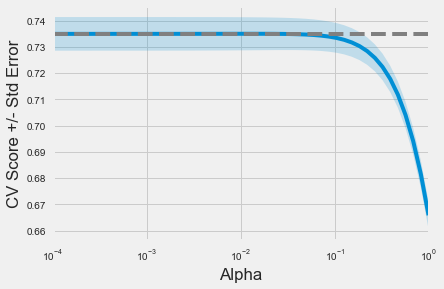

R^2: 0.7379622864140494
Root Mean Squared Error: 0.6892941710077506
Average 5-Fold CV Score: 0.7349262486801086
[0.72243234 0.75345857 0.71492177 0.73926567 0.7445529 ]


In [360]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:
    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha

    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train_s, y_train_s, cv=10)

    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))

    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.01, normalize=True)

#Fit the model
ridge.fit(X_train_s, y_train_s)

#Predict
y_pred_s_ridge = ridge.predict(X_test_s)

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X_train_s, y_train_s, cv=5)

print("R^2: {}".format(ridge.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s_ridge))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(ridge_cv)))
# Print the 5-fold cross-validation scores
print(ridge_cv)
q11={'ridge':{
    'r^2':ridge.score(X_test_s, y_test_s),
    'rmse':rmse,
    '5-fold csv':np.mean(ridge_cv),
    'predicted value':list(y_pred_s_ridge)
}}
q1.update(q11)
data.append(q1)

#print(data)

# df1=pd.DataFrame(y_pred_s_ridge,columns=['ridge_regression'])
# df.append(df1)
# print(df)

### Lasso Regression

In [361]:
X_train_s.shape, y_train_s.shape
X_test_s.shape, y_test_s.shape

alpha = 0.00099

from sklearn.linear_model import Lasso
lasso_regr = Lasso(alpha = alpha, max_iter=50000)
lasso_regr.fit(X_train_s, y_train_s)
y_pred_lasso = lasso_regr.predict(X_test_s)
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_lasso))
rmse

lasso_cv = cross_val_score(lasso_regr, X_train_s, y_train_s, cv=5)
print("Average 5-Fold CV Score: {}".format(np.mean(lasso_cv)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_lasso))
print("Root Mean Squared Error: {}".format(rmse))
print("R^2: {}".format(lasso_regr.score(X_test_s, y_test_s)))

q12={'lasso':{
    'r^2':lasso_regr.score(X_test_s, y_test_s),
    'rmse':rmse,
    '5-fold csv':np.mean(lasso_cv),
    'predicted value':list(y_pred_lasso)
}}
q1.update(q12)
data.append(q1)

#print(data)

Average 5-Fold CV Score: 0.7349097392169033
Root Mean Squared Error: 0.689084461299777
R^2: 0.7381217059927292


### Elasticnet and GridSearch

In [362]:
#Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor 
#of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.


# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

#The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the
#param_grid parameter.

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
#print(gm_cv)

# Fit it to the training data
gm_cv.fit(X_train_s, y_train_s)
#print(gm_cv.fit(X_train_s, y_train_s))

# Predict on the test set and compute metrics
y_pred_elas = gm_cv.predict(X_test_s)
r2 = gm_cv.score(X_test_s, y_test_s)
mse = mean_squared_error(y_test_s, y_pred_elas)

q13={'elasticNet':{
    'r^2':r2,
    'mse':mse,
    'predicted value':list(y_pred_elas)
}}
q1.update(q13)
data.append(q1)

#print(data)

In [363]:
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.7391828488493946
Tuned ElasticNet MSE: 0.47291333190572016


### Random Forest

R^2: 0.9686497857631109
Root Mean Squared Error: 0.23842015267539235
Average 5-Fold CV Score: 0.9667958915726371
[0.96944094 0.96861905 0.96929743 0.95959908 0.96702296]
                        0         1
1               IC50 (µM)  0.726541
3                    Amax  0.158171
0               EC50 (µM)  0.077930
4  Activity Data (median)  0.020319
5             Activity SD  0.011219
2              Doses (uM)  0.005820


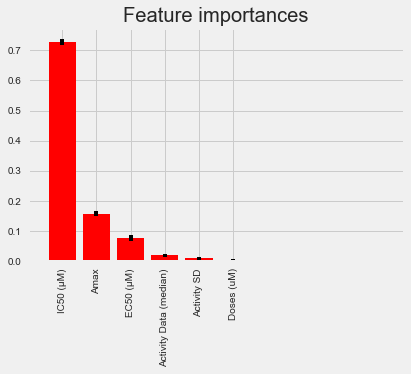

In [374]:
rf_reg = RandomForestRegressor()

model=rf_reg.fit(X_train_s, y_train_s)

y_pred_s_rf = rf_reg.predict(X_test_s)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_rf = cross_val_score(rf_reg, X_train_s, y_train_s, cv=5)

print("R^2: {}".format(rf_reg.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s_rf))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_rf)))
# Print the 5-fold cross-validation scores
print(cv_scores_rf)

importance = pd.DataFrame(list(zip(X_train_s.columns, np.transpose(rf_reg.feature_importances_))) \
            ).sort_values(1, ascending=False)
print(importance)
importances = rf_reg.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_s.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_s.shape[1]),X_train_s.columns[indices], rotation=90)
#plt.xlim([-1, X_train_s.shape[1]])
plt.xlim([-1, 10])
plt.show()

# import pickle
# #rf_reg

# # Dump the trained decision tree classifier with Pickle
# decision_tree_pkl_filename = 'rf_reg.pkl'
# # Open the file to save as pkl file
# decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
# pickle.dump(rf_reg, decision_tree_model_pkl,'Utf-8')
# # Close the pickle instances
# decision_tree_model_pkl.close()

# q14={'random_forest':{
#     'r^2':rf_reg.score(X_test_s, y_test_s),
#     'rmse':rmse,
#     '5-fold csv':np.mean(cv_scores_rf),
#     'predicted value':list(y_pred_s_rf)
# }}
# q1.update(q14)
# data.append(q1)

#print(data)

In [421]:

import pickle
# save the classifier
# s=pickle.dumps(model)
# clf2 = pickle.loads(s)
# clf2.predict([[3.456,5.67,8.120,-41.45678,-71.987654,2.777777]])


pickle_out = open("dict.pkl","wb")
s=pickle.dumps(model)
pickle_out.write(s)
pickle_out.close()

clf2 = pickle.loads(s)
clf2.predict([[3.456,5.67,8.120,-41.45678,-71.987654,2.777777]])


array([0.80903])

In [277]:
# df1=pd.DataFrame([[y_pred_s],[y_pred_s_ridge]],columns=['linear_regression','ridge_regression'])

df11 = pd.DataFrame(q1)
#df11.lasso[2]
df11.head()
#df11.lasso[2]


,elasticNet,lasso,linear,random_forest,ridge
5-fold csv,NaN,0.73491,0.734908,0.965682,0.734926
mse,0.472913,NaN,NaN,NaN,NaN
predicted value,"[0.6650622255505045, 0.6543220654507648, 1.155...","[0.5023171727952145, 0.5624944174829878, 1.008...","[[0.5003444825498506], [0.5612880198733965], [...","[0.84002, 0.73477, 0.54162, 3.5352599999999996...","[[0.5068607050679581], [0.5686787843548287], [..."
r^2,0.739183,0.738122,0.738098,0.968434,0.737962
rmse,NaN,0.689084,0.689116,0.239241,0.689294


In [278]:
df.to_json(r'./oneeeee.json')